# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.



# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [ ]:
!gdown --id 1Ah5uV6cu3Bnz6WfkUuxEZCLqj5k1lbpd

#這兩行程式是設定訓練資料（training data）與測試資料（testinlg data）的檔案名稱。後續載入資料時會使用這兩個變數。
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

#這行使用 gdown 這個工具（可從 Google Drive 下載檔案）來：
#從 Google Drive 上的檔案 ID 為 '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' 下載檔案
#儲存為本地檔案 covid.train.csv這就是訓練資料檔案。
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ah5uV6cu3Bnz6WfkUuxEZCLqj5k1lbpd
To: /content/ML2025Spring-hw2-public.zip
100% 621k/621k [00:00<00:00, 126MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 36.6MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
F

# **Import Some Packages**

In [ ]:
# 這三行是 PyTorch 的核心模組，功能如下：
# torch: Tensor 操作、模型計算等的主要工具
# torch.nn: 提供深度學習中常用的神經網路層（如 Linear、ReLU 等）
# Dataset 與 DataLoader: 處理自定義資料集與小批量資料的迭代器（batch training）
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 這些套件是用來進行前處理的：
# numpy: 常用的數值運算（例如標準化、矩陣操作）
# csv: 處理 .csv 格式資料的原始方法
# os: 處理路徑與檔案操作，例如檢查檔案是否存在等
import numpy as np
import csv
import os

# 這部分是用來畫圖，常用於：
# 損失函數（loss）或準確率（accuracy）的變化圖
# 模型訓練過程的視覺化
# 結果的展示（例如模型預測 vs 真實值）
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# 這段非常關鍵，用來確保模型訓練的結果可重現。說明如下：
# myseed = 42069：自訂的亂數種子值

# 許多 GPU 上的高效運算（例如 convolution、pooling）會有多種演算法實作。
# cuDNN/CUDA 會根據當下硬體條件挑選最快的方式，但有些實作是非確定性的。
# 這意味著：相同輸入 ➜ 有可能產生不同輸出。
# torch.backends.cudnn.deterministic = True：強制 cudnn 使用確定性算法（可重現但可能較慢）
# torch.backends.cudnn.benchmark = False：禁用動態最佳化（因為會導致不可預測性）
# np.random.seed(myseed)：固定 NumPy 的隨機性
# torch.manual_seed(myseed)：固定 CPU 上的 PyTorch 隨機性
# torch.cuda.manual_seed_all(myseed)：若使用 GPU，固定 GPU 上的隨機性

# 為什麼要設定 seed？
# 深度學習過程中，許多步驟都涉及隨機性，例如：
# 權重初始化 -> 每層的 weight 隨機生成
# 資料增強 / 抽樣順序 -> 每個 epoch shuffle
# dropout -> 每次會隨機遮掉神經元
# batchnorm -> 依據 batch 計算 mean/std
# torch.randn / np.random.randn -> 明確的亂數產生

myseed = 42077
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [ ]:
#Get device (if GPU is available, use GPU)
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

#畫出訓練過程中的 Train Loss vs Dev Loss（驗證損失）曲線
#Train Loss（訓練損失）：模型在訓練資料（training set）上的平均誤差。
#Dev Loss（開發集損失）：模型在驗證資料（validation set，也叫 dev set）上的平均誤差。
#每個 epoch 結束後，使用 model.eval() + torch.no_grad() 在驗證集上預測，然後計算損失。
def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()



from sklearn.metrics import r2_score, mean_squared_error

#畫出模型預測值 vs 真實值（ground truth）的散佈圖，幫助你視覺化預測準確度
#紅點越靠近藍線 → 預測越準確
#點均勻分布在藍線兩側且無明顯偏離趨勢 → 模型沒有系統性誤差（bias）
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    ###
    r2 = r2_score(targets, preds)
    mse = mean_squared_error(targets, preds)
    plt.text(2, 32, f'R²: {r2:.3f}\nMSE: {mse:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ####
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## Feature Selection

⚠️ 1. 特徵過多導致訓練效率低下

若有大量結構化特徵（如實驗數據、Vitals、ICD codes），仍可能因維度過高造成訓練困難，這時 feature selection 可以減少 noise。

⚠️ 2. 資料樣本數不夠時

深度模型在小樣本下容易 overfitting，這時減少特徵維度能提升泛化能力。

⚠️ 3. 可解釋性需求高時

醫療領域常需要解釋模型決策，這時預先挑選關鍵特徵有助於後續模型詮釋。

###Feature Selection Explain

這段程式碼是導入 Scikit-learn（sklearn） 套件中與「特徵選擇與標準化」有關的模組，常用於資料前處理與降維。

📌 from sklearn.feature_selection import SelectKBest
這是導入一個特徵選擇工具：

🎯 功能：從全部特徵中選出前 K 個「與目標變數最相關」的特徵
這是進行降維與特徵工程常見的第一步，可幫助：
移除不相關/冗餘特徵
降低過擬合風險
提升模型訓練效率與可解釋性

📌 from sklearn.feature_selection import f_regression
這是 SelectKBest 所需的 打分機制（scoring function）。

🎯 功能：對每個數值型特徵計算與連續型目標（回歸任務）間的線性關聯性（F 分數）
底層使用 ANOVA F-test，分數越高代表該特徵對目標值影響越大。

📌 from sklearn import preprocessing
這是導入 sklearn 中常用的資料前處理模組，裡面包含許多工具，例如：

| 常用功能       | 用途                                  |
|----------------|---------------------------------------|
| StandardScaler | Z-score 標準化（均值 0、標準差 1）    |
| MinMaxScaler   | 將數據縮放到 0～1 區間                |
| LabelEncoder   | 將分類標籤轉為數字                    |
| OneHotEncoder  | 類別變數轉為 one-hot                  |

➡️ 可用來進行正規化、標準化、特徵轉換等操作。

SelectKBest(f_regression) 挑出 對目標變數影響最大的前幾個特徵。
✅ 根據 F-score 排序後，選出的「最佳特徵索引」清單
selected_features = [75, 57, 42, 60, 78, ...]
X_selected = X[:, selected_features]

In [ ]:
# Pandas
import pandas as pd

# Sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

# Feature Selection

data = pd.read_csv(r'covid.train.csv')
x = data[data.columns[1:94]]
y = data[data.columns[94]]

# Normalisation
x = (x - x.min()) / (x.max() - x.min())

# Create an instance of SelectKBest without specifying 'k'
bestfeatures = SelectKBest(score_func=f_regression)

# Compute the scores for all features
fit = bestfeatures.fit(x,y)

# Convert the scores into a DataFrame
dfscores = pd.DataFrame(fit.scores_)

# Create a DataFrame of the column names
dfcolumns = pd.DataFrame(x.columns)

# Concatenate the two DataFrames for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

# Name the DataFrame columns
featureScores.columns = ['Specs','Score']

# Print the 20 rows with the highest scores
print(featureScores.nlargest(25,'Score'))

# Print the index of the most important features
top_rows = featureScores.nlargest(25, 'Score').index.tolist()[:25]
print(top_rows)

                   Specs          Score
75     tested_positive.1  148069.658278
57       tested_positive   69603.872591
42          hh_cmnty_cli    9235.492094
60        hh_cmnty_cli.1    9209.019558
78        hh_cmnty_cli.2    9097.375172
43        nohh_cmnty_cli    8395.421300
61      nohh_cmnty_cli.1    8343.255927
79      nohh_cmnty_cli.2    8208.176435
40                   cli    6388.906849
58                 cli.1    6374.548000
76                 cli.2    6250.008702
41                   ili    5998.922880
59                 ili.1    5937.588576
77                 ili.2    5796.947672
92    worried_finances.2     833.613191
74    worried_finances.1     811.916460
56      worried_finances     788.076931
87      public_transit.2     686.736539
69      public_transit.1     681.562902
51        public_transit     678.834789
83                shop.2     561.764051
65                shop.1     553.876727
47                  shop     546.553395
91  worried_become_ill.2     208.122647


## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

讓target_only = True 然後用我們的Feature Selection

### 🎯 若你想再進一步：

| 目標               | 可做的升級                                                |
|--------------------|-----------------------------------------------------------|
| 更動特徵不改程式碼 | 將 `feats` 存成外部檔案（例如 `.npy` 或 `.json`）動態讀入 |
| 多標籤任務         | 支援 `target = data[:, -n:]`，處理多欄目標輸出              |
| 使用資料標頭       | 若 CSV 含欄位名稱，改用 `pandas` 並建立特徵名稱對應表       |

In [ ]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=True,
                 mean=None,
                 std=None):
      ##讓target_only = True 然後用我們的Feature Selection
        self.mode = mode


      # --- 1) load raw data and select features --------------------
        # Read data into numpy arrays
        # 去掉標頭列與第一欄 id
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(data.shape[1] - (mode != 'test')))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # 來自 SelectKBest(f_regression) 的排名
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77, 92]


        # test 模式不含標籤，只回傳特徵
        # train/dev 模式：抽出最後一欄作為 label（ground truth）
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            target = None
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]


        # --- 2) split indices ----------------------------------------
            # Splitting training data into train & dev sets
            #保持可重現的 9:1 定點切分
        if mode == 'train':
            indices = [i for i in range(len(data)) if i % 10 != 0]
        elif mode == 'dev':
            indices = [i for i in range(len(data)) if i % 10 == 0]
        else:
            indices  = list(range(len(data)))

        train_data = data[indices]

        # Convert data into PyTorch tensors
        if mode != 'test':
          self.target = torch.FloatTensor(target[indices])

        # --- 3) normalize --------------------------------------------

        # 作者原本希望在使用全部特徵時（target_only=False）：前 40 個特徵是州別類別（不標準化），從第 40 維開始才做標準化
        # 使用 target_only=True（例如只取幾個精選特徵）：有可能會把前 40 維都拿掉（如只保留第 57、75 等）
        # 在 target_only=True 的情況下，這段根本不會執行（因為維度只有17）
        # 等於你實際沒做任何標準化，這會讓特徵值尺度不一，模型訓練不穩
        # this is incorrect after feature selection: normalize_start_index = 40
        # after feature selection, we ignore one Hot features, hence we can normalize everything

        eps = 1e-8
        if self.mode == 'train':
            train_mean = train_data.mean(axis=0, keepdims=True)
            train_std  = train_data.std(axis=0,  keepdims=True) + eps
        # On the other hand the orignial code normalized everything
        # making data leakage from the dev & test data
        else:
            assert mean is not None and std is not None, "Dev/test require train mean/std"
            train_mean, train_std = mean, std

        normalized = (train_data - train_mean) / train_std
        self.data  = torch.FloatTensor(normalized)
        self.mean, self.std = train_mean, train_std
        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training 訓練或驗證模型時用，必須包含真實標籤
            return self.data[index], self.target[index]
        else:
            # For testing (no target) 測試階段無標籤，模型只會做預測
            return self.data[index]

    #這讓 DataLoader 知道一共要跑幾輪、幾個 batch。
    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.

✅ 根據模式（train/dev/test）建立 COVID19Dataset，然後包裝成 DataLoader，提供給模型迭代讀取。

✅ 將你定義好的 Dataset，打包成「一批一批的資料」，讓模型在訓練或推論時高效、有條理地讀取。



### 🔍 DataLoader 能做什麼？功能總覽



| 功能               | 說明                                                        |
|--------------------|-------------------------------------------------------------|
| **Batching（分批）**       | 將資料切成每批 `batch_size` 筆                              |
| **Shuffling（隨機排序）** | 每次訓練打亂順序，提升泛化能力                               |
| **Multi-processing（多執行緒讀取）** | 平行從硬碟或記憶體讀取，加快速度                    |
| **Pin Memory**      | 用 pinned memory 提升 GPU 資料傳輸效率                       |
| **Drop last**       | 控制是否丟棄最後不足一整批的資料                              |
| **Iterable**        | 可用 `for batch in dataloader:` 的方式逐批取資料              |


####Shuffle
每個 epoch 開始前，重新隨機排列 Dataset 的索引順序。
這可避免模型依賴資料的既定排列（例如所有陽性病例都在一起），強迫它從資料本身學到泛化規律。
- 如有極端不均衡資料時，光打亂可能不足以解決偏斜。
- 若你的資料帶有時間序列依賴（e.g. 逐日疫情走勢），則應改用自訂 Sampler 以保留時序結構。

####Drop_last
資料筆數若無法整除 batch_size，最後不足一整批的樣本是否 直接棄掉。
設 False ⇒ 保留零碎 batch；設 True ⇒ 直接忽略。
- 設 True 會丟失少量資料（約 < 1 × batch_size）。
- 設 False 時，最後一批樣本數量變少，BN/Dropout 統計稍有偏差，但通常影響可忽略。

####Pin_memory
使用 CUDA 時，先在 page-locked（pinned）主記憶體 配置張量，再一次性 DMA 拷貝到 GPU，減少 CPU ↔ GPU 傳輸延遲。
影像、表格、時間序列… 只要 GPU 訓練，一律 pin_memory=True；若記憶體吃緊，可視情況關閉或降低 batch_size。


###實作

In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, mean=None, std=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only, mean=mean, std=std)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                           # Construct dataloader
    return dataloader, dataset.mean, dataset.std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(16, 1)
        )


        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)


    #L2 對所有權重施加「平方懲罰」，使參數趨向小但不為 0
    #L1 在 optimization 過程中對 gradient 的導數是非連續的（在 0 處），訓練不如 L2 穩定
    def cal_loss(self, pred, target, config):
        '''Calculate loss with optional L1 regularization from config'''

        base_loss = self.criterion(pred, target)
        l1_lambda = config.get('l1_lambda', 0.0)

        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in self.parameters())  # ← 這裡修正
            loss = base_loss + l1_lambda * l1_norm
        else:
            loss = base_loss

        return loss


# **Train/Dev/Test**

## **Training**

In [ ]:
import os
import torch
from torch.optim.lr_scheduler import OneCycleLR

def eval_loss(dataloader, model, device, config):
    '''计算 dataloader 上的 MSE，使用 eval 模式'''
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = model.cal_loss(pred, y, config)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def train(tr_set, dv_set, model, config, device):
    # 1. 建立 optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    # 2. 在 train 里实例化 OneCycleLR
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config['max_lr'],
        epochs=config['n_epochs'],
        steps_per_epoch=len(tr_set),
        pct_start=config['pct_start'],
        anneal_strategy=config['anneal_strategy']
    )

    min_mse = float('inf')
    early_stop_cnt = 0
    loss_record = {'train': [], 'dev': []}

    for epoch in range(config['n_epochs']):
        model.train()
        for x, y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            loss = model.cal_loss(model(x), y, config)
            loss.backward()
            optimizer.step()
            scheduler.step()   # ← OneCycleLR 要每个 batch 调用

        # 3. 统一在 eval 模式下计算 Train/Dev MSE
        train_mse = eval_loss(tr_set, model, device, config)
        dev_mse   = eval_loss(dv_set, model, device, config)
        loss_record['train'].append(train_mse)
        loss_record['dev'].append(dev_mse)

        # 4. 每 10 个 epoch 或最后一轮打印一次
        if (epoch + 1) % 10 == 0 or (epoch + 1) == config['n_epochs']:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"[Epoch {epoch+1:4d}] "
                  f"Train MSE: {train_mse:.4f} | "
                  f"Dev   MSE: {dev_mse:.4f} | LR: {current_lr:.6f}")

        # 5. Early stopping & 保存最优模型
        if dev_mse < min_mse:
            min_mse = dev_mse
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
            if early_stop_cnt > config['early_stop']:
                print(f"Early stopping at epoch {epoch+1}.")
                break

    print(f"Finished training after {epoch+1} epochs.")
    return min_mse, loss_record

## **Validation**

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, config)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [ ]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                  # TODO: Using 40 states & 2 tested_positive features 改成 True

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 64,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'weight_decay': 1e-6
    },
    'scheduler': {
        max_lr=5e-2,
        epochs=config['n_epochs'],
        steps_per_epoch=len(tr_set),
        pct_start=0.3,
        anneal_strategy='linear'
    },
    'l1_lambda': 1e-5,
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}


SyntaxError: unterminated string literal (detected at line 15) (ipython-input-209-377813530.py, line 15)

# **Load data and model**

In [ ]:
tr_set, train_mean, train_std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set, _, _ = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, mean=train_mean, std=train_std)
tt_set, _, _ = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=train_mean, std=train_std)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 15)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 15)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 15)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

[Epoch   10] Train MSE: 1.1466 | Dev   MSE: 1.0769 | LR: 0.002595
[Epoch   20] Train MSE: 1.2676 | Dev   MSE: 1.1698 | LR: 0.000412
[Epoch   30] Train MSE: 1.1148 | Dev   MSE: 1.0406 | LR: 0.000119
[Epoch   40] Train MSE: 1.1108 | Dev   MSE: 1.0383 | LR: 0.000101
[Epoch   50] Train MSE: 1.1117 | Dev   MSE: 1.0398 | LR: 0.000100
[Epoch   60] Train MSE: 1.1164 | Dev   MSE: 1.0436 | LR: 0.000100
[Epoch   70] Train MSE: 1.1303 | Dev   MSE: 1.0493 | LR: 0.000100
[Epoch   80] Train MSE: 1.1039 | Dev   MSE: 1.0249 | LR: 0.000100
[Epoch   90] Train MSE: 1.0903 | Dev   MSE: 1.0231 | LR: 0.000100
[Epoch  100] Train MSE: 1.0951 | Dev   MSE: 1.0177 | LR: 0.000100
[Epoch  110] Train MSE: 1.1219 | Dev   MSE: 1.0327 | LR: 0.000100
[Epoch  120] Train MSE: 1.0827 | Dev   MSE: 1.0068 | LR: 0.000100
[Epoch  130] Train MSE: 1.1306 | Dev   MSE: 1.0394 | LR: 0.000100
[Epoch  140] Train MSE: 1.1302 | Dev   MSE: 1.0385 | LR: 0.000100
[Epoch  150] Train MSE: 1.0679 | Dev   MSE: 0.9899 | LR: 0.000100
[Epoch  16

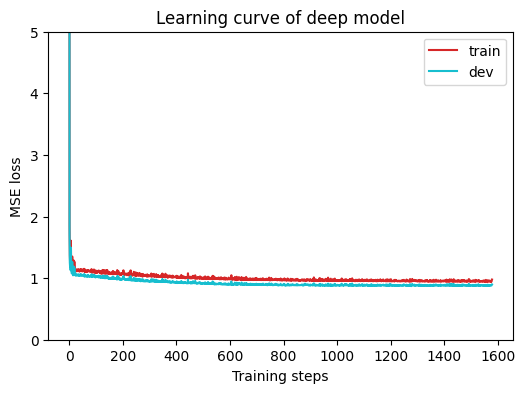

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

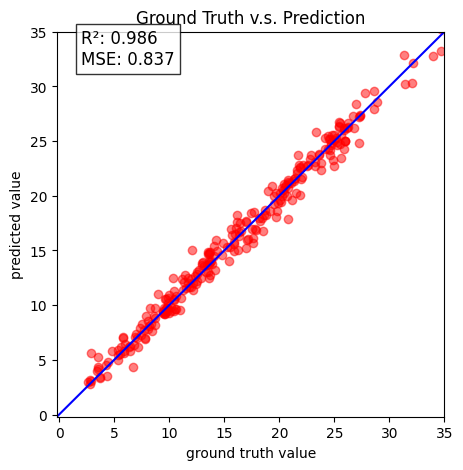

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# 🧪 Baseline Model Summary

---

## ✅ Simple Baseline
- ✅ Ran the provided sample code successfully.
- 🔹 This serves as the basic pipeline without optimizations or feature engineering.

---

## 🔸 Medium Baseline

### 🔍 Feature Selection
- Selected 40 states + 2 `tested_positive` columns.
- Originally, `tested_positive` was marked as `TODO` in the dataset.
- ✅ Confirmed `tested_positive` features are among the most important for prediction.

---

## 💪 Strong Baseline

### 🔍 Feature Selection
- Feature selection is **crucial** when training data is limited.
- Used **ANOVA F-test (`f_classif` from `sklearn`)** to identify the most informative features beyond `tested_positive`.

---

### 🧠 DNN Architecture
- ✅ **Activation**: ReLU used instead of Sigmoid.
  - 🔹 Avoids vanishing gradients.
  - 🔹 Accelerates training convergence.
- ✅ **Dropout** applied:
  - Reduces overfitting.
  - Slightly increases training loss due to added noise.
  - ⚠️ Should evaluate validation loss, not just training loss.
- ⚠️ **Batch Normalization**:
  - Not recommended together with Dropout in small models — can interfere with learning.
  - Use one at a time unless working with larger models.

---

### 🏋️ Training Setup

- ✅ **Mini-batch size** reduced from `270 → 128`:
  - More stochasticity.
  - Powers of 2 are GPU-friendly.
- ✅ **Optimizer**:
  - **Adam**: Converges faster but risks overfitting on small models.
  - **SGD**: Slower, but better generalization in small-data regimes.
- ✅ **Learning rate** tuning:
  - Consider scheduler (e.g., cosine annealing or step decay) when using SGD.

---

### 🧰 Regularization

- ✅ **L2 Regularization**:
  - Implemented via `weight_decay` in optimizer (e.g., PyTorch/TF).
  - Helps reduce model complexity and overfitting.

---

## ⚠️ Code Mistakes & Fixes

### ❌ Target-Only Normalization
- The sample code normalizes only the **target variable**.
- ✅ **Fix**: Normalize **input features as well**, after feature selection.

### ❌ Data Leakage in Normalization
- Original code normalizes using **all data** (train + test) — this is **data leakage**.
- ✅ **Fix**:
  - Compute normalization parameters (mean, std) **from training data only**.
  - Apply the same transformation to validation and test sets.

---

> ✅ Next steps: Use validation curves and ablation studies to fine-tune architecture choices.




# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)


In [ ]:
!git --version

git version 2.34.1


In [ ]:
!git config --global user.name "ericsson0408"
!git config --global user.email "ericsson.lahm@gmail.com"

In [ ]:
!git clone https://github.com/ericsson0408/MLHW.git

Cloning into 'MLHW'...


In [ ]:
import nbformat
from google.colab import drive

# Save notebook to working directory
notebook_path = 'ML2021-HW1.ipynb'

with open(notebook_path, 'w') as f:
    nbformat.write(nbformat.from_dict({
        "cells": [],
        "metadata": {},
        "nbformat": 4,
        "nbformat_minor": 0
    }), f)

In [ ]:
cp ML2021-HW1.ipynb MLHW/

In [ ]:
%cd MLHW
!git add .
!git commit -m "Add notebook from Colab"

/content/MLHW
[main (root-commit) 485d1d0] Add notebook from Colab
 1 file changed, 6 insertions(+)
 create mode 100644 ML2021-HW1.ipynb


Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Delta compression using up to 2 threads
Compressing objects: 100% (2/2), done.
Writing objects: 100% (3/3), 284 bytes | 284.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/ericsson0408/MLHW.git
 * [new branch]      main -> main
